In [52]:
import warnings
from numba.core.errors import NumbaWarning
warnings.filterwarnings("ignore", category=NumbaWarning)

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import umap
import umap.plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [54]:
from numba import jit

@jit
def my_func(x):
    return x + 1

# Avoid re-calling @jit if unnecessary
result1 = my_func(10)
result2 = my_func(20)

In [55]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('confusion matrix')
    print(confusion)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [56]:
dataframe = pd.read_csv('shuffled_allfinalcopy6.csv', header=None)
raw_data = dataframe.values
dataframe.head().style.set_properties(**{'background-color': 'black',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407


In [57]:
import plotly.graph_objects as go

# Define target labels and colors
colors = ['gold', 'mediumturquoise']  # Colors for pie chart sections
labels = ['Oscillation (Normal)', 'Nonblocked (Abnormal)']  # Updated labels for your dataset

# Calculate distribution of target values
target_column = dataframe.iloc[:, -1]  # Target column is the last column
values = target_column.value_counts(normalize=True)  # Proportions of each class

# Plot the pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(
    hoverinfo='label+percent',
    textinfo='percent',
    textfont_size=20,
    marker=dict(colors=colors, line=dict(color='white', width=0.1))
)
fig.update_layout(
    title_text="THz Dataset",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()


In [58]:
# Separate features and labels
raw_data = np.loadtxt("shuffled_allfinalcopy6.csv", delimiter=",")  # Or other loading method

labels = raw_data[:, -1]  # Last column as labels
data = raw_data[:, :-1]   # All other columns as features

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [59]:
import numpy as np

# Check class distribution in the original dataset
unique, counts = np.unique(labels, return_counts=True)
print("Original Label Distribution:", dict(zip(unique, counts)))

# Check class distribution in the training set
unique, counts = np.unique(train_labels, return_counts=True)
print("Training Label Distribution:", dict(zip(unique, counts)))

# Check class distribution in the testing set
unique, counts = np.unique(test_labels, return_counts=True)
print("Testing Label Distribution:", dict(zip(unique, counts)))

Original Label Distribution: {1.0: 240, 2.0: 240}
Training Label Distribution: {1.0: 193, 2.0: 191}
Testing Label Distribution: {1.0: 47, 2.0: 49}


In [60]:
# Normalize the data to [0, 1] range
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Convert data to TensorFlow tensors with dtype float32
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [61]:
# Convert labels to booleans: True for oscillation (1), False for nonblock (2)
train_labels = (train_labels == 1)
test_labels = (test_labels == 1)

print("The length of train:", len(train_labels))
print("The length of test:", len(test_labels))

# Separate the data into normal (nonblock) and anomalous (oscillation) subsets
normal_train_data = train_data[~train_labels]  # Nonblock (label = 2)
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]  # Oscillation (label = 1)
anomalous_test_data = test_data[test_labels]     # Oscillation (label = 1)

# Print the shapes of the subsets for verification
print("Normal(Oscillation) train data shape:", normal_train_data.shape)
print("Anomalous(Non-Block) train data shape:", anomalous_train_data.shape)
print("Normal test(Oscillation) data shape:", normal_test_data.shape)
print("Anomalous(Non-Block) test data shape:", anomalous_test_data.shape)
print(normal_train_data)

The length of train: 384
The length of test: 96
Normal(Oscillation) train data shape: (191, 1500)
Anomalous(Non-Block) train data shape: (193, 1500)
Normal test(Oscillation) data shape: (49, 1500)
Anomalous(Non-Block) test data shape: (47, 1500)
tf.Tensor(
[[0.82257265 0.82267135 0.82275355 ... 0.8192783  0.81929195 0.8192872 ]
 [0.81678325 0.8169569  0.8171297  ... 0.79463595 0.7946338  0.7946317 ]
 [0.813938   0.81396    0.81398195 ... 0.80882585 0.80858207 0.8083664 ]
 ...
 [0.8152567  0.8151939  0.81513137 ... 0.79891783 0.79880154 0.7986859 ]
 [0.8202336  0.8202241  0.8202147  ... 0.81217825 0.81229657 0.8123805 ]
 [0.93926805 0.9392247  0.93917274 ... 0.9386066  0.9385488  0.9384913 ]], shape=(191, 1500), dtype=float32)


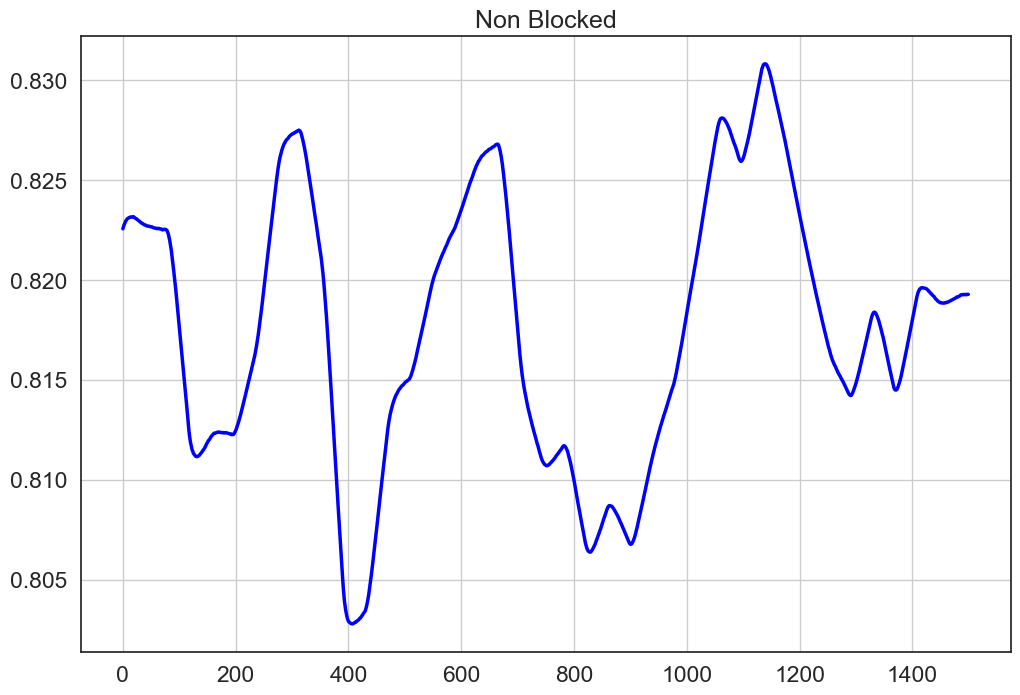

In [62]:
plt.figure(figsize=(12, 8))  # Adjusting figure size for better clarity
sns.set_theme(context="notebook", style="white", font_scale=1.5)     # Adjust font scale for readability
sns.set_style("white")       # Use a clean style
plt.grid(visible=True)       # Enable grid

# Plot the first row of normal_train_data
plt.plot(np.arange(1500), normal_train_data[0], color='blue', linewidth=2.5)  # Updated range to 1500
plt.title("Non Blocked", fontsize=18)  # Updated title


# Show the plot
plt.show()

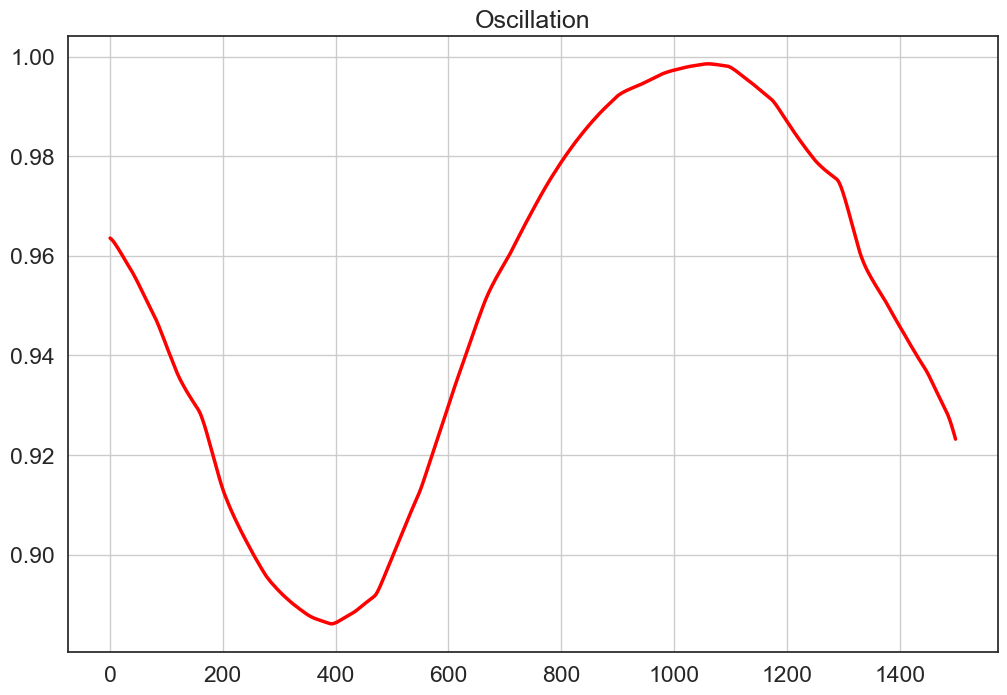

In [63]:
plt.figure(figsize=(12, 8))  # Adjusting figure size for better clarity
sns.set_theme(context="notebook", style="white", font_scale=1.5)    # Adjust font scale for readability
sns.set_style("white")       # Use a clean style
plt.grid(visible=True)       # Enable grid

plt.plot(np.arange(1500), anomalous_train_data[0], color='red', linewidth=2.5)
plt.title("Oscillation", fontsize=18)


# Show the plot
plt.show()

In [64]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        
        # Encoder: Specify the input shape explicitly
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(1500,)),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu")
])
        
        # Decoder: Matches the output of encoder and reconstructs the original shape
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(32,)),  # Input shape is the output size of the encoder
            layers.Dense(64, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(1500, activation="sigmoid")  # Output shape matches input data
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the autoencoder model
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

# Print the model summary
autoencoder.build(input_shape=(None, 1500))  # Define the input shape to fully build the model
print(autoencoder.summary())


Model: "anomaly_detector_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 32)             │       427,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 1500)           │       428,956 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 856,444 (3.27 MB)

 Trainable params: 856,444 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

None


In [65]:
# Re-split and reshape
from sklearn.model_selection import train_test_split

# Assuming `data` is the full dataset
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# # Check if the new splits work with reshaping
# X_train = X_train.reshape(-1, 1500)
# X_test = X_test.reshape(-1, 1500)

In [66]:
input_shape = X_train.shape[1]  # Number of features
autoencoder.encoder.layers[0] = layers.Input(shape=(input_shape,))
autoencoder.decoder.layers[-1] = layers.Dense(input_shape, activation="sigmoid")
reconstructed = autoencoder.predict(train_data)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [67]:
print("train_data shape:", X_train.shape)
print("test_data shape:", X_test.shape)

# If there are adjustments applied to test_data
print("test_data shape after adjustment:", X_test.shape)
print("Reconstructed shape:", reconstructed.shape)


train_data shape: (384, 1500)
test_data shape: (96, 1500)
test_data shape after adjustment: (96, 1500)
Reconstructed shape: (384, 1500)


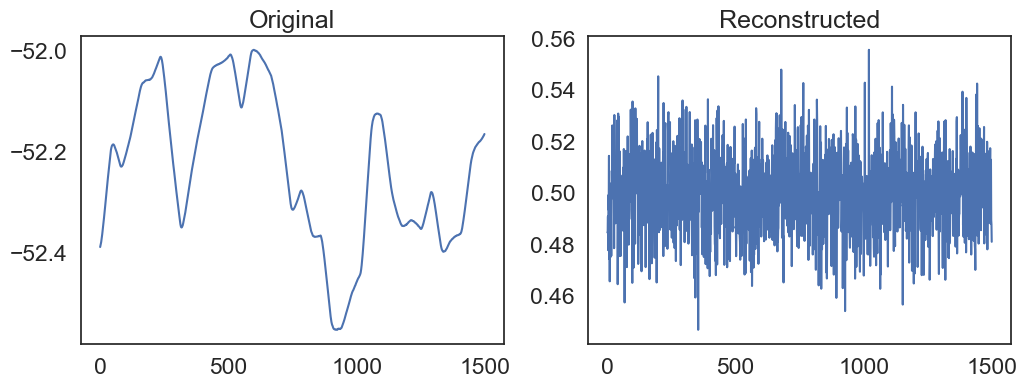

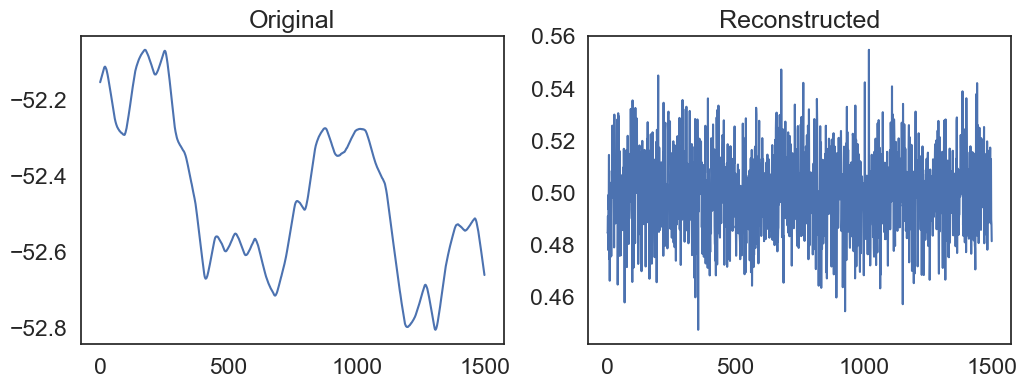

In [68]:
# Plot original and reconstructed for comparison
for i in range(2):  # Display 5 examples
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.plot(X_test[i])
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed")
    plt.plot(reconstructed[i])
    plt.show()

In [69]:
history = autoencoder.fit(
    train_data, train_data,  # Input and target are the same for autoencoders
    epochs=100,
    batch_size=32,
    validation_data=(test_data, test_data),
    # validation_split=0.2,
    shuffle=True
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2686 - val_loss: 0.0722
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0651 - val_loss: 0.0588
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0437 - val_loss: 0.0414
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0380 - val_loss: 0.0395
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364 - val_loss: 0.0374
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0339 - val_loss: 0.0364
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0340 - val_loss: 0.0363
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0356 - val_loss: 0.0366
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0365 - val_loss: 0.0362
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0354 - val_loss: 0.0367
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0324 - val_loss: 0.0364
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

In [70]:
reconstructed = autoencoder.predict(test_data)
loss = tf.keras.losses.mae(test_data, reconstructed)
print("Reconstruction loss:", loss)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction loss: tf.Tensor(
[0.02007688 0.01519261 0.01558467 0.0143201  0.06700709 0.00964829
 0.01409275 0.02750337 0.008975   0.0657842  0.01078498 0.02523743
 0.01527874 0.07000487 0.06793497 0.01109141 0.00842163 0.06707043
 0.01541915 0.01766913 0.0151656  0.00991129 0.00918045 0.0122231
 0.06627223 0.06521133 0.07348215 0.07075539 0.01339616 0.01403493
 0.01956331 0.01041133 0.06999479 0.07098899 0.01081924 0.01731918
 0.01313458 0.06676059 0.01313549 0.0683364  0.01280479 0.01452799
 0.06305609 0.02892324 0.01133458 0.06672831 0.07278658 0.03158671
 0.01234466 0.01554127 0.06967607 0.01209666 0.07101306 0.01406617
 0.01302906 0.00887908 0.06863452 0.06688938 0.07077993 0.02338452
 0.00573077 0.02924806 0.06658841 0.01161118 0.01522752 0.07127889
 0.01725767 0.06502084 0.01267461 0.06844352 0.06946834 0.02112052
 0.01847162 0.06862552 0.01363671 0.01721494 0.01538134 0.02029834
 0.01921114 0.00985397 0.01143179 0.01451559 0.01279601 0.009

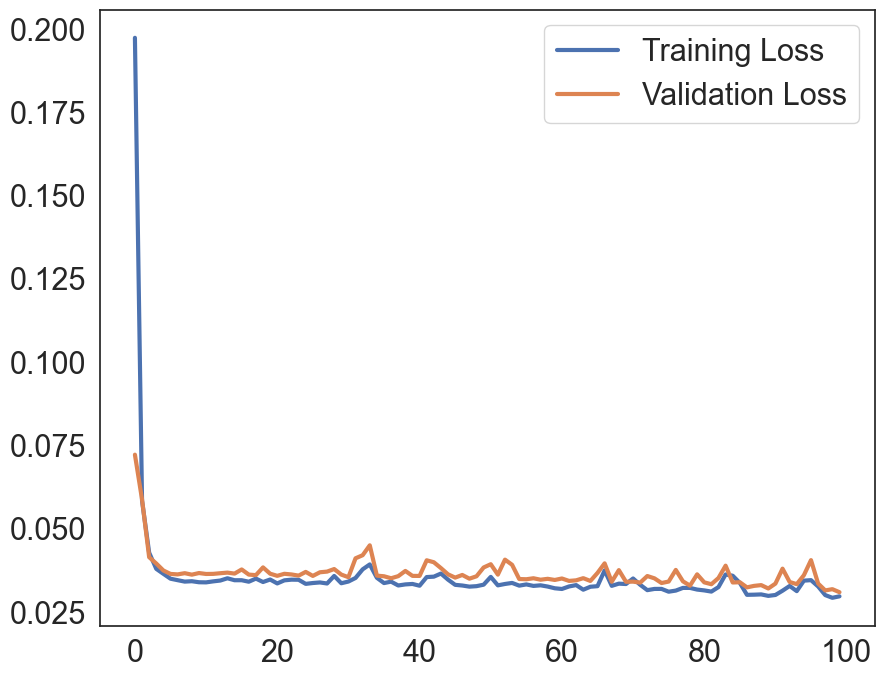

In [71]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

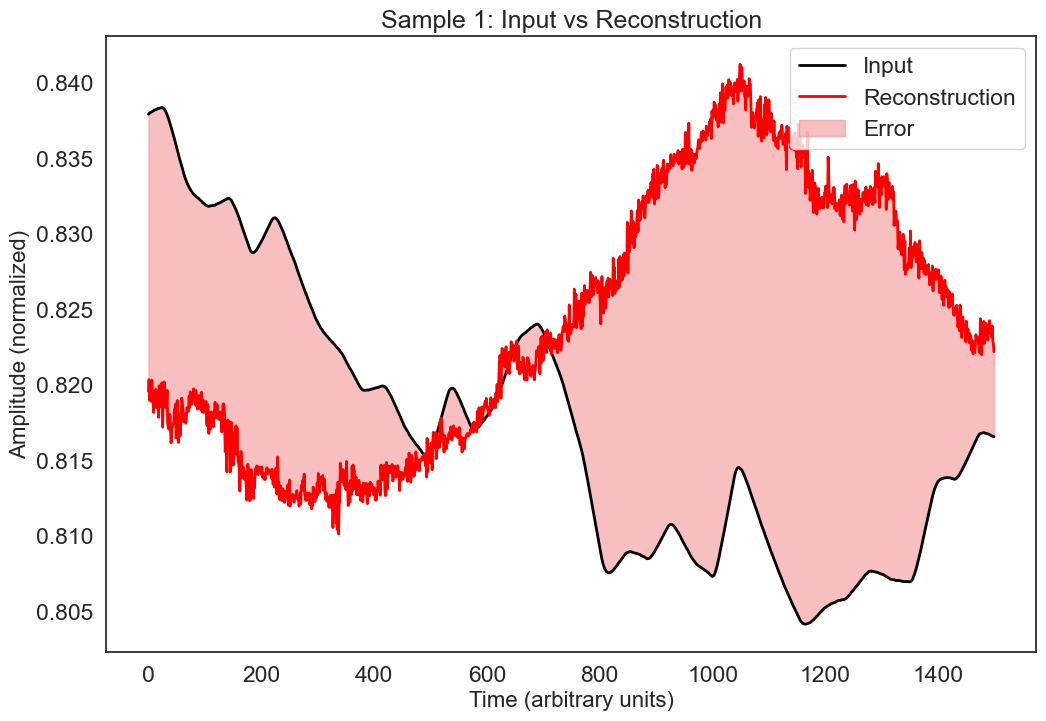

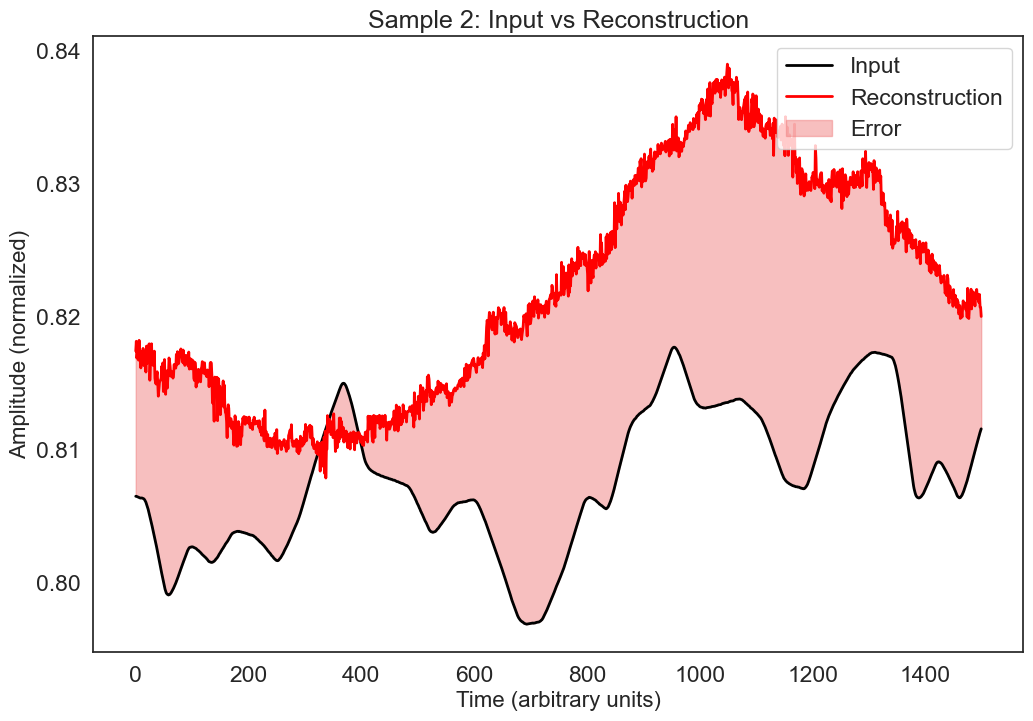

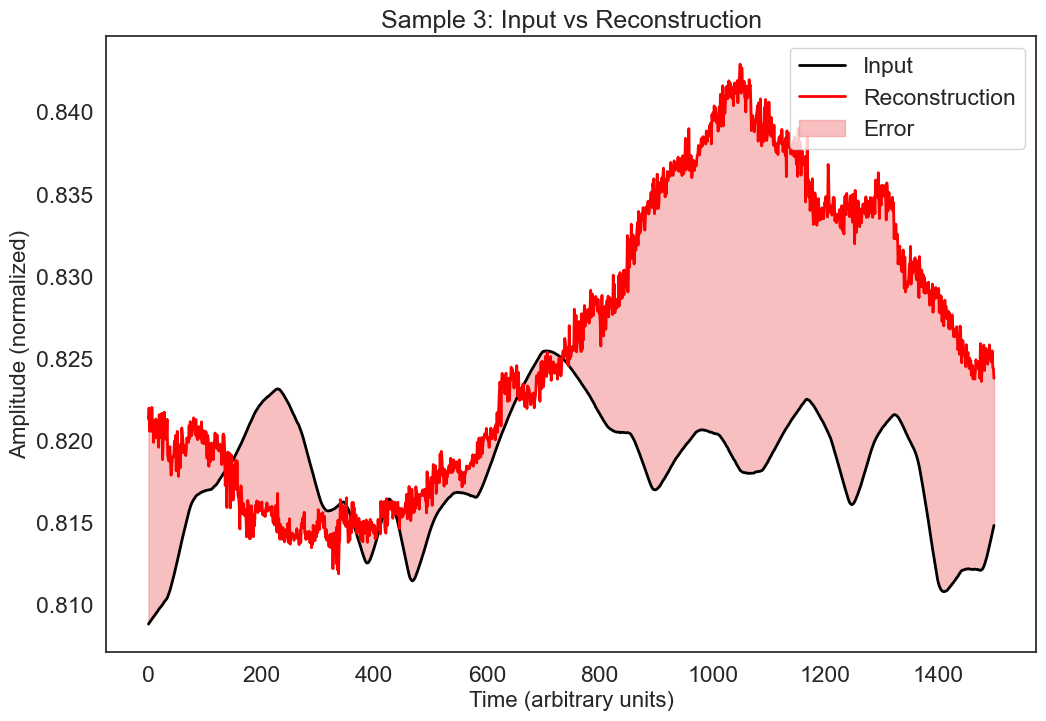

In [72]:
# Encode and decode the test data
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Visualize the original vs. reconstructed data for the first three samples
for i in range(3):  # Loop through the first 3 samples
    plt.figure(figsize=(12, 8))  # Adjust figure size for better clarity
    sns.set(font_scale=1.5)      # Adjust font scale
    sns.set_style("white")       # Use clean white style
    
    # Plot the original input data (black line)
    plt.plot(normal_test_data[i], color='black', linewidth=2, label="Input")
    
    # Plot the reconstructed data (red line)
    plt.plot(decoded_imgs[i], color='red', linewidth=2, label="Reconstruction")
    
    # Highlight the reconstruction error with a fill between
    plt.fill_between(
        np.arange(1500),  # Updated to match the length of your features
        decoded_imgs[i], 
        normal_test_data[i], 
        color='lightcoral', 
        alpha=0.5, 
        label="Error"
    )
    
    # Add legend and labels
    plt.legend(loc="upper right")
    plt.title(f"Sample {i + 1}: Input vs Reconstruction", fontsize=18)
    plt.xlabel("Time (arbitrary units)", fontsize=16)
    plt.ylabel("Amplitude (normalized)", fontsize=16)
    
    # Show the plot
    plt.show()


In [73]:
encoded_imgs_normal = pd.DataFrame(encoded_imgs)
encoded_imgs_normal['label'] = 1

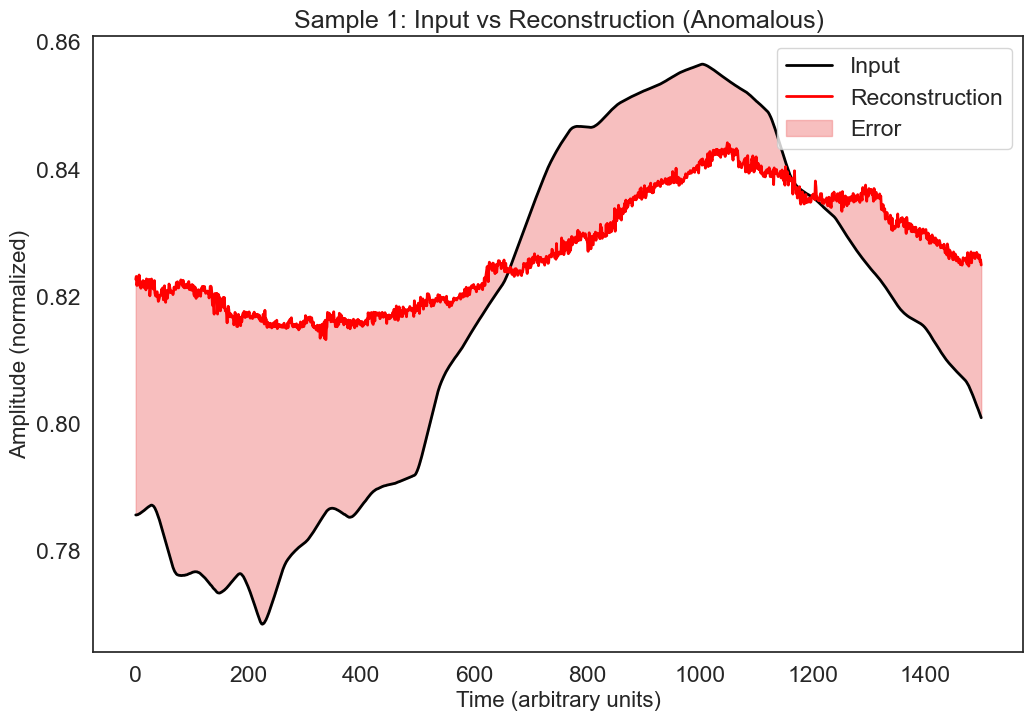

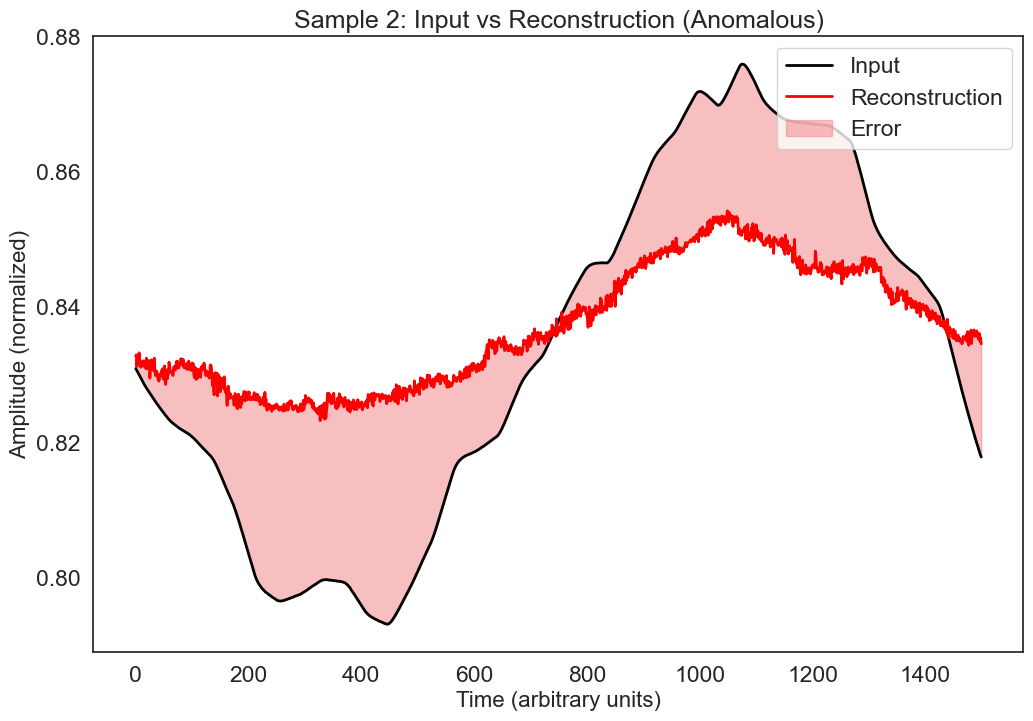

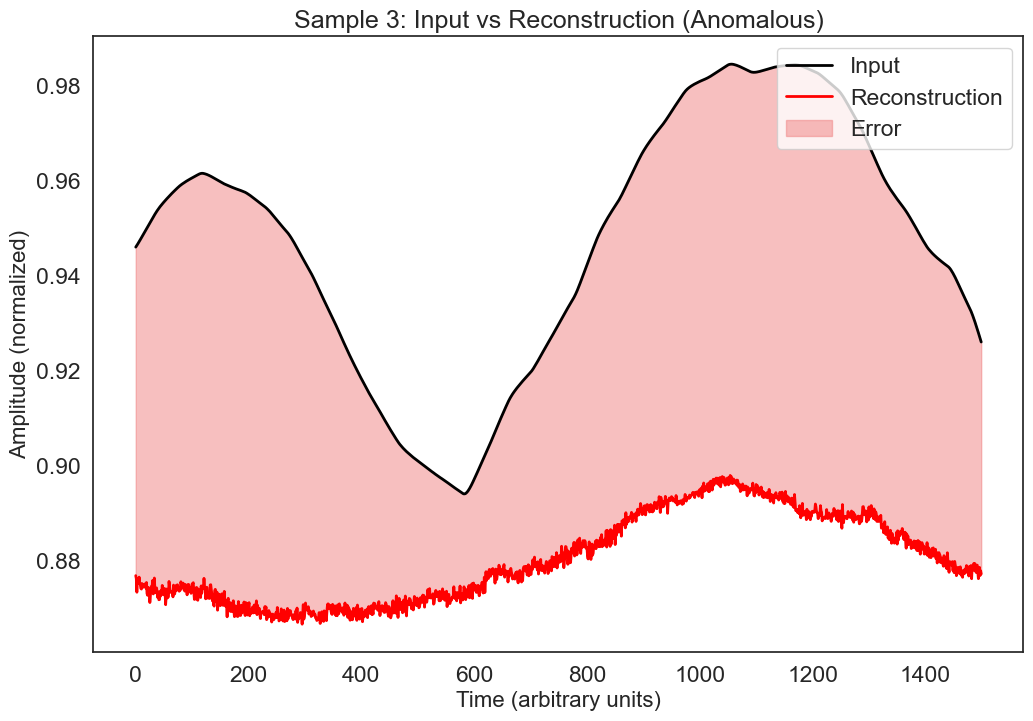

In [74]:
# Encode and decode the anomalous test data
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Visualize the original vs. reconstructed data for the first three anomalous samples
for i in range(3):  # Loop through the first 3 samples
    plt.figure(figsize=(12, 8))  # Adjust figure size for better clarity
    sns.set(font_scale=1.5)      # Adjust font scale
    sns.set_style("white")       # Use clean white style
    
    # Plot the original anomalous input data (black line)
    plt.plot(anomalous_test_data[i], color='black', linewidth=2, label="Input")
    
    # Plot the reconstructed data (red line)
    plt.plot(decoded_imgs[i], color='red', linewidth=2, label="Reconstruction")
    
    # Highlight the reconstruction error with a fill between
    plt.fill_between(
        np.arange(1500),  # Updated to match the length of your features
        decoded_imgs[i], 
        anomalous_test_data[i], 
        color='lightcoral', 
        alpha=0.5, 
        label="Error"
    )
    
    # Add legend and labels
    plt.legend(loc="upper right")
    plt.title(f"Sample {i + 1}: Input vs Reconstruction (Anomalous)", fontsize=18)
    plt.xlabel("Time (arbitrary units)", fontsize=16)
    plt.ylabel("Amplitude (normalized)", fontsize=16)
    
    # Show the plot
    plt.show()


In [75]:
encoded_imgs_abnormal = pd.DataFrame(encoded_imgs)
encoded_imgs_abnormal['label'] = 0

In [76]:
all_encoded = pd.concat([encoded_imgs_normal,encoded_imgs_abnormal])

/Users/humayrajeba/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



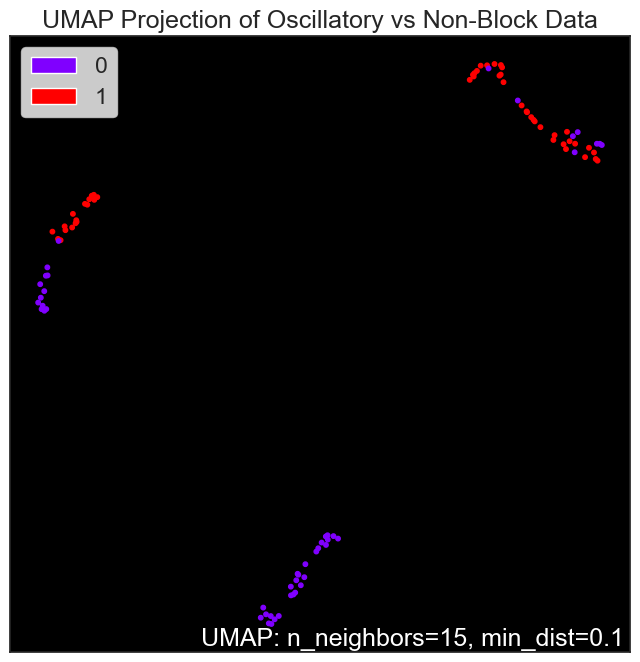

In [77]:
# Assuming `all_encoded` contains 1500 features + 1 label column (at index 1500)
# Prepare the data
feature_columns = all_encoded.iloc[:, :-1]  # All columns except the last one (features)
label_column = all_encoded.iloc[:, -1]      # The last column (labels)

# Fit UMAP to the feature columns
mapper = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42).fit(feature_columns)

# Plot the UMAP results with labels
umap.plot.points(mapper, labels=label_column, theme='fire')

# Add a title and show the plot
plt.title("UMAP Projection of Oscillatory vs Non-Block Data")
plt.show()

In [78]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [79]:
np.mean(train_loss)

0.025123792

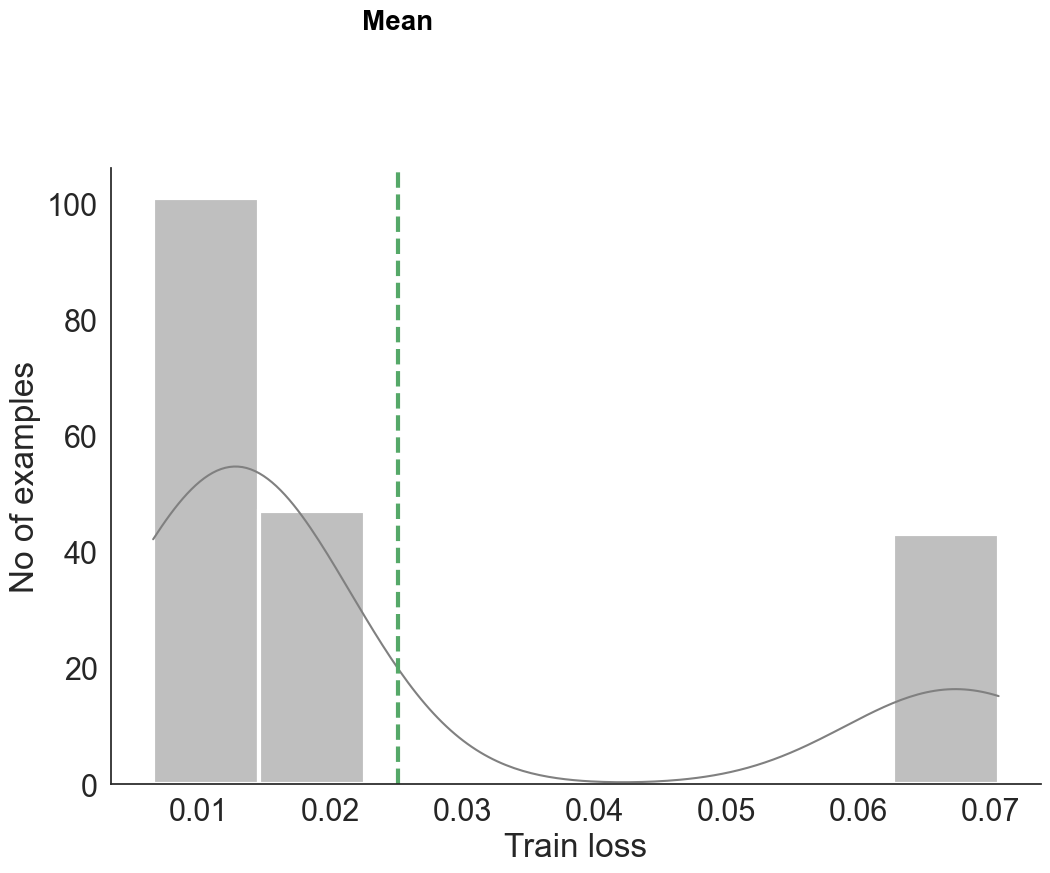

In [80]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=8,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 130, "Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In [81]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.04806578


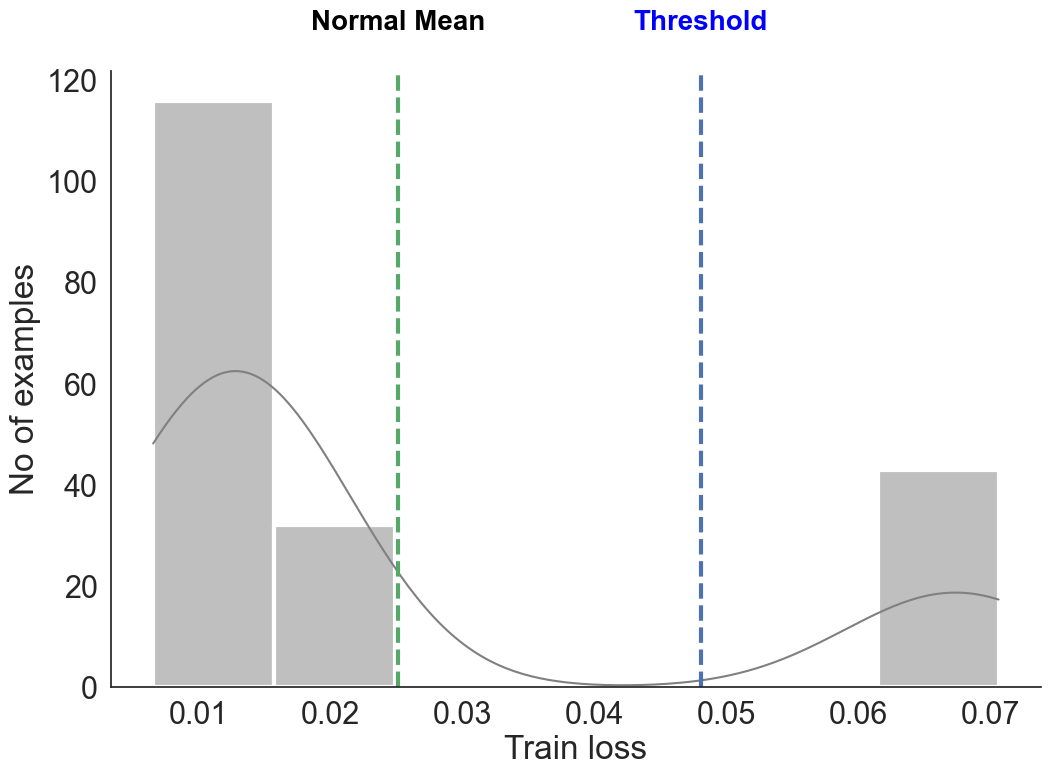

In [82]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=7,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 130, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 130, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

In [83]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [84]:
np.mean(test_loss)

0.029820386

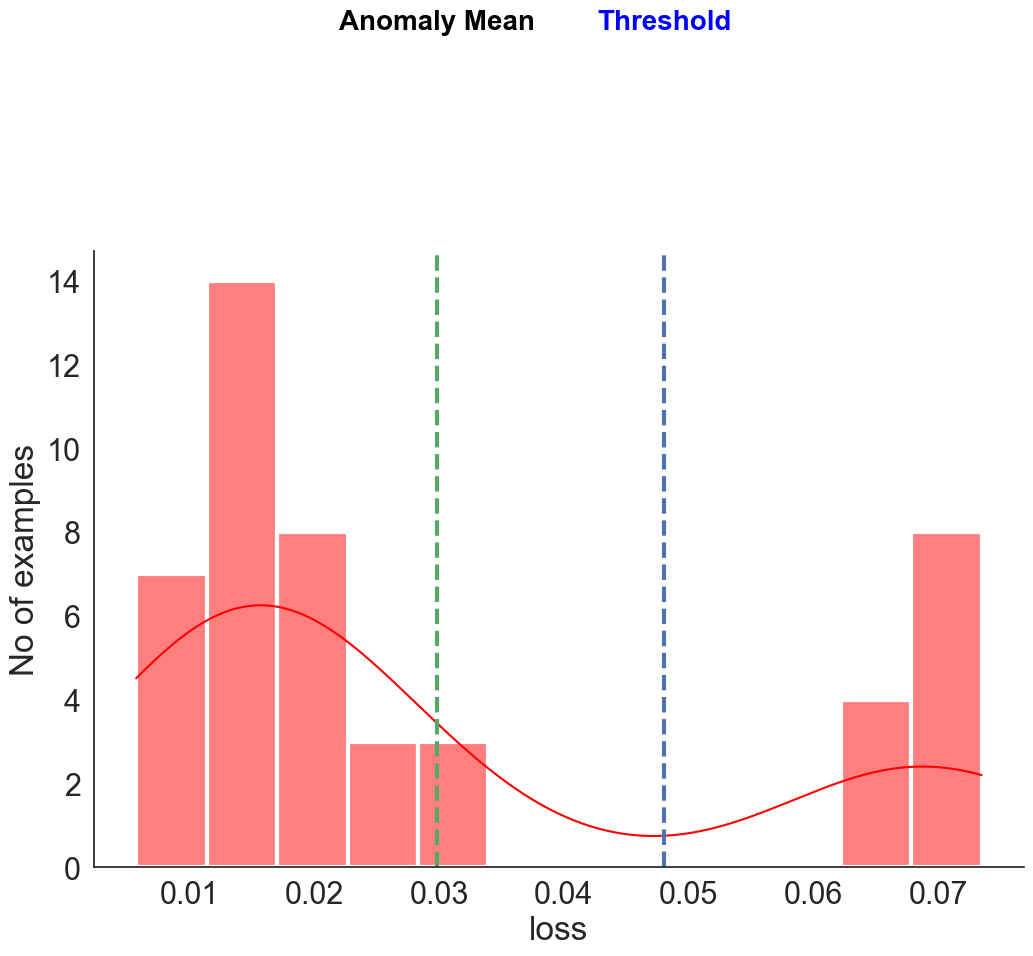

In [85]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(test_loss ,bins=12,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 20, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.text(threshold, 20, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

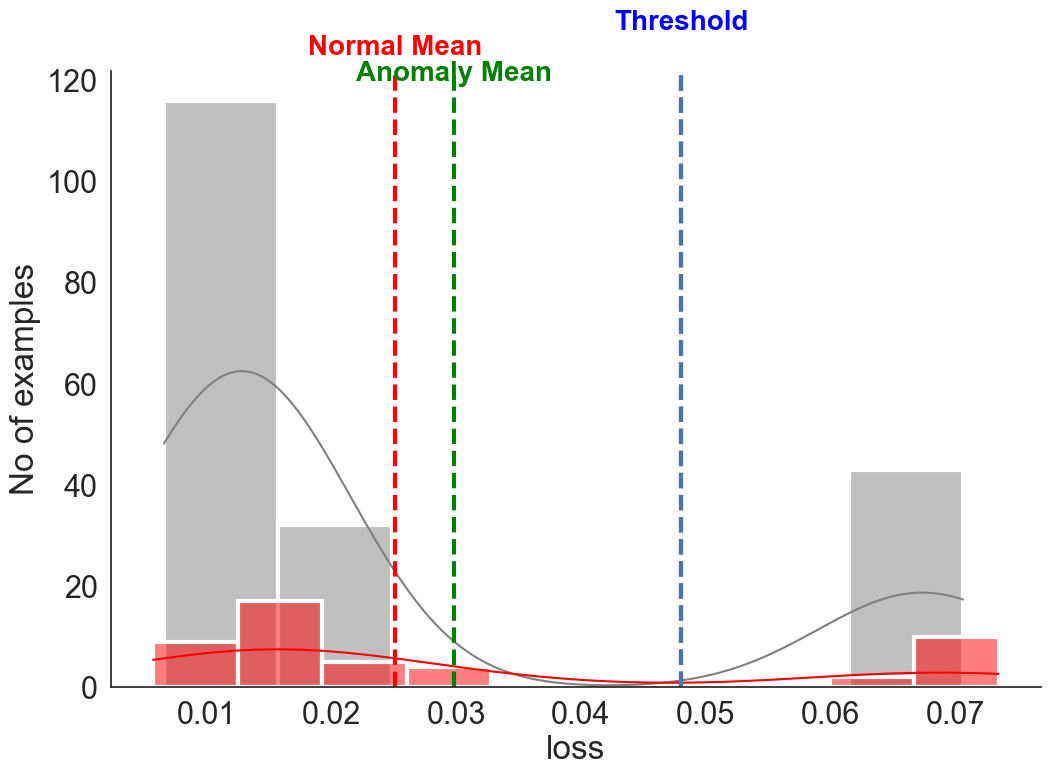

In [86]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=7,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='red', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 125, "Normal Mean", horizontalalignment='center', 
         size='small', color='red', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 130, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=10,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='green', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 120, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='green', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

In [87]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    # Convert predictions to a more accessible format if needed
    preds = predictions.numpy() if hasattr(predictions, 'numpy') else predictions
    
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [88]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.5416666666666666
Precision = 0.5223880597014925
Recall = 0.7446808510638298


Accuracy: 0.5416666666666666
Precision: 0.5223880597014925
F1 Score: 0.6140350877192983


<Axes: >

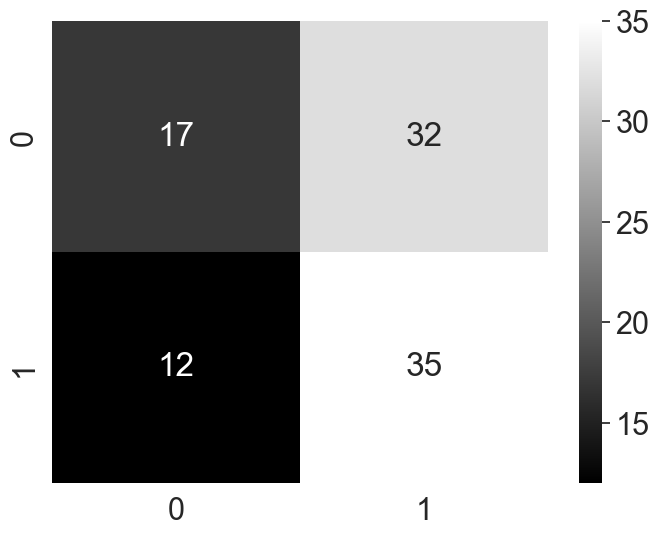

In [89]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)  # Confusion matrix
    accuracy = accuracy_score(y_test, pred)  # Accuracy score
    precision = precision_score(y_test, pred)  # Precision score
    f1 = f1_score(y_test, pred)  # F1 score

    return confusion, accuracy, precision, f1  # Return confusion matrix and all metrics

# Assuming test_labels and preds are defined
confusion_matrix_result, accuracy, precision, f1 = get_clf_eval(test_labels, preds)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=2)
sns.set_style("white")
sns.heatmap(confusion_matrix_result, cmap='gist_yarg_r', annot=True, fmt='d')


In [90]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # Example model

model = RandomForestClassifier(random_state=21)
scores = cross_val_score(model, data, labels, cv=5, scoring='accuracy')
print("Cross-validation Accuracy:", scores.mean())


Cross-validation Accuracy: 0.9604166666666666


In [91]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, data, labels, cv=5, scoring='f1')
print(f"Cross-validation Mean F1 Score: {scores.mean()}")

Cross-validation Mean F1 Score: 0.9596748868007206


In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

# Define the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model on the training data
model.fit(train_data, train_labels)

# Predict on the test data
predicted = model.predict(test_data)

# Calculate accuracy (classification-like for regression with rounded predictions)
accuracy = accuracy_score(test_labels, predicted.round()) * 100

# Print results
print("The accuracy of Random Forest is:", accuracy, "%")
print("Mean Squared Error (MSE):", mean_squared_error(test_labels, predicted))


The accuracy of Random Forest is: 97.91666666666666 %
Mean Squared Error (MSE): 0.020057291666666668


**# Accuracy: 97.91%**

This is very high, suggesting the model is predicting well. However, in regression tasks, accuracy based on rounded predictions is not the most standard metric (it’s more common in classification).

**# Mean Squared Error (MSE): 0.020**

This is a good sign if our target variable is normalized or on a small scale. A lower MSE indicates that the model's predictions are very close to the true values.

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Initialize the Decision Tree Regressor
# model = DecisionTreeRegressor(criterion='squared_error', random_state=0, max_depth=5)

# # Fit the model to the training data
# model.fit(train_data, train_labels)

# # Predict on the test data
# predictions = model.predict(test_data)

# # Evaluate the model
# mse = mean_squared_error(test_labels, predictions)
# mae = mean_absolute_error(test_labels, predictions)
# r2 = r2_score(test_labels, predictions)

# print(f"Mean Squared Error (MSE): {mse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")
# print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.0408
Mean Absolute Error (MAE): 0.0497
R² Score: 0.8367


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

### Accuracy ###
Random Forest: 0.9479
Decision Tree: 0.9688
XGBoost: 0.9688
Autoencoder: 0.4896


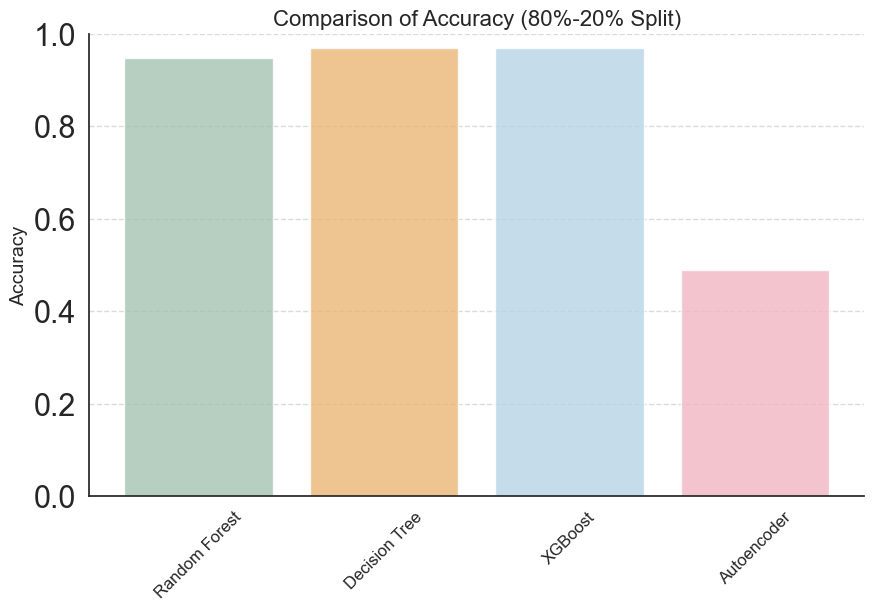


### Precision ###
Random Forest: 0.9375
Decision Tree: 0.9583
XGBoost: 0.9400
Autoencoder: 0.4896


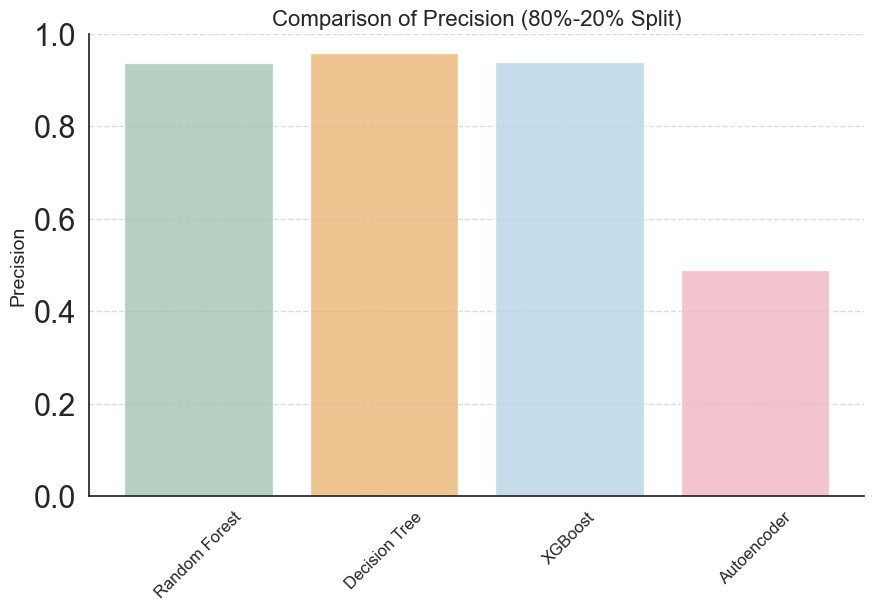


### Recall ###
Random Forest: 0.9574
Decision Tree: 0.9787
XGBoost: 1.0000
Autoencoder: 1.0000


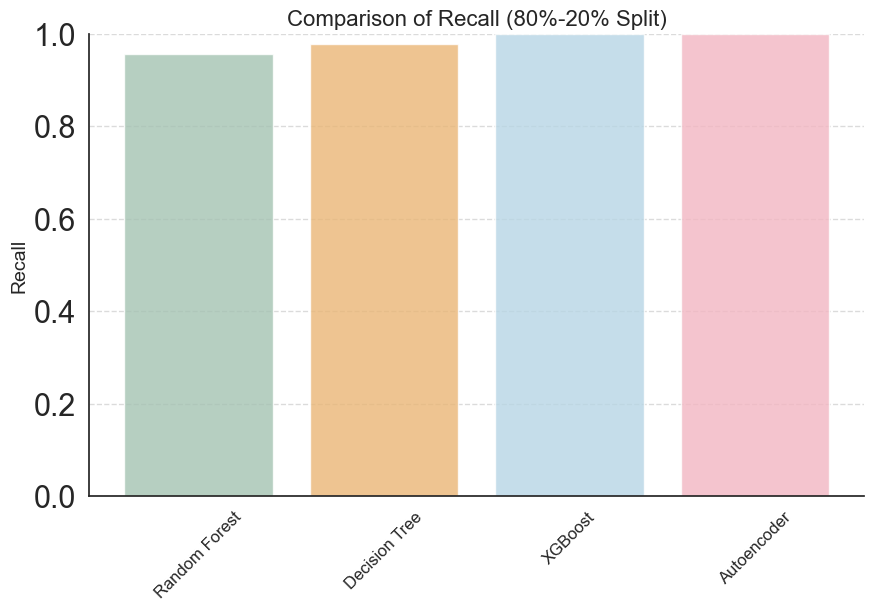


### F1 ###
Random Forest: 0.9474
Decision Tree: 0.9684
XGBoost: 0.9691
Autoencoder: 0.6573


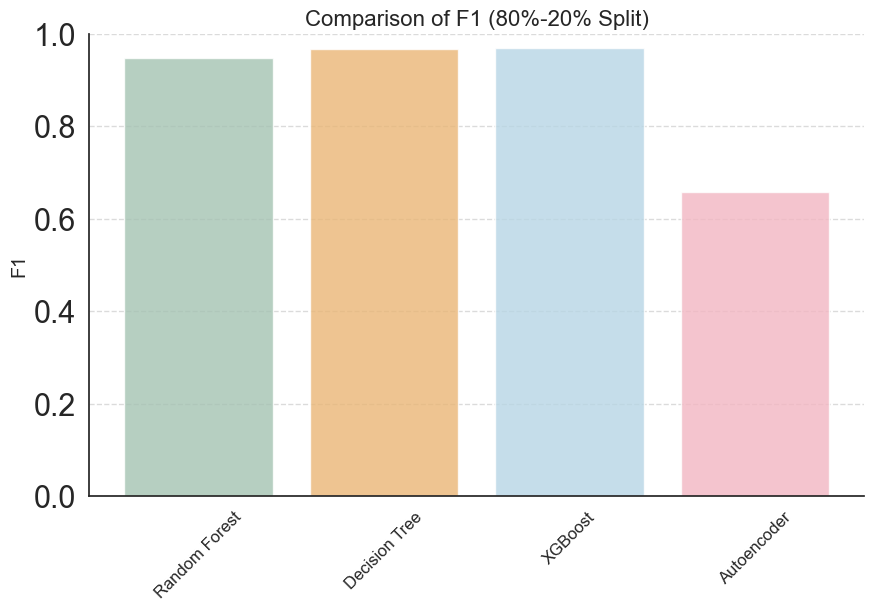

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import tensorflow as tf

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Adjust labels from [1, 2] to [0, 1]
y_train = y_train - 1
y_test = y_test - 1

# Placeholder for metrics
results = {
    "Random Forest": {},
    "Decision Tree": {},
    "XGBoost": {},
    "Autoencoder": {}
}

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
results["Random Forest"] = {
    "accuracy": accuracy_score(y_test, rf_preds),
    "precision": precision_score(y_test, rf_preds),
    "recall": recall_score(y_test, rf_preds),
    "f1": f1_score(y_test, rf_preds),
}

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)
results["Decision Tree"] = {
    "accuracy": accuracy_score(y_test, dt_preds),
    "precision": precision_score(y_test, dt_preds),
    "recall": recall_score(y_test, dt_preds),
    "f1": f1_score(y_test, dt_preds),
}

# XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')  # Removed 'use_label_encoder'
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
results["XGBoost"] = {
    "accuracy": accuracy_score(y_test, xgb_preds),
    "precision": precision_score(y_test, xgb_preds),
    "recall": recall_score(y_test, xgb_preds),
    "f1": f1_score(y_test, xgb_preds),
}


# Autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, verbose=0, shuffle=True)
reconstructed = autoencoder.predict(X_test)
loss = tf.keras.losses.mae(X_test, reconstructed).numpy()
threshold = np.mean(loss) + np.std(loss)
preds = (loss < threshold)
results["Autoencoder"] = {
    "accuracy": accuracy_score(y_test, preds),
    "precision": precision_score(y_test, preds),
    "recall": recall_score(y_test, preds),
    "f1": f1_score(y_test, preds),
}

# Plot metrics
import seaborn as sns

# Define light colors for each model
colors = {
    "Random Forest": "#A4C3B2",
    "Decision Tree": "#EAB676",
    "XGBoost": "#B7D5E5",
    "Autoencoder": "#F2B6C2",
}

metrics = ["accuracy", "precision", "recall", "f1"]

for metric in metrics:
    print(f"\n### {metric.capitalize()} ###")
    
    # Print metric values for each model
    for model in results.keys():
        print(f"{model}: {results[model][metric]:.4f}")
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Get values for all models
    models = results.keys()
    values = [results[model][metric] for model in models]
    
    # Bar plot
    plt.bar(models, values, color=[colors[model] for model in models], alpha=0.8)
    
    # Formatting the plot
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.title(f"Comparison of {metric.capitalize()} (80%-20% Split)", fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.ylim(0, 1)  # All metrics are in the range [0, 1]
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    sns.despine()  # Remove top and right spines
    
    plt.show()

